## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from torch.nn import Parameter
from matplotlib import pyplot as plt
import seaborn as sns
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, MultiOutputGP
from lafomo.plot import Plotter
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.data import p53_ground_truth

Let's start by importing our dataset...

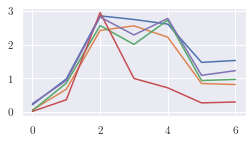

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

Differential equation here: ....

Since this is an ordinary differential equation (ODE), we inherit from the `OrdinaryLFM` class.

In [3]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config)
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

In [4]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    kernel_scale=False,
    initial_conditions=False
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)
step_size = 1e-1

gp_model = MultiOutputGP(inducing_points, num_tfs)
lfm = TranscriptionLFM(num_genes, gp_model, config)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

In [5]:
class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        super().after_epoch()
        # self.cholS.append(self.lfm.q_cholS.detach().clone())
        # self.mus.append(self.lfm.q_m.detach().clone())
        with torch.no_grad():
            # TODO can we replace these with parameter transforms like we did with lengthscale
            # self.lfm.sensitivity.clamp_(0, 20)
            self.lfm.basal_rate.clamp_(0, 20)
            self.lfm.decay_rate.clamp_(0, 20)
            self.lfm.sensitivity[3] = np.float64(1.)
            self.lfm.decay_rate[3] = np.float64(0.8)

track_parameters = [
    'basal_rate',
    'decay_rate',
    'sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.03)
trainer = P53ConstrainedTrainer(lfm, optimizer, dataset, track_parameters=track_parameters)

### Outputs prior to training:

/Users/jacob/Documents/proj/reggae/lafomo/plot/plotter.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


MultitaskMultivariateNormal(loc: torch.Size([80]))

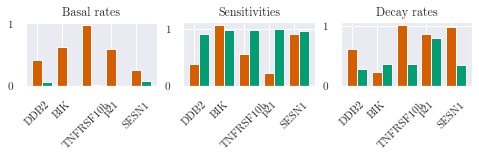

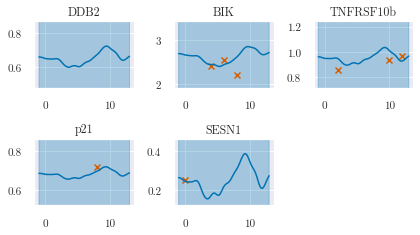

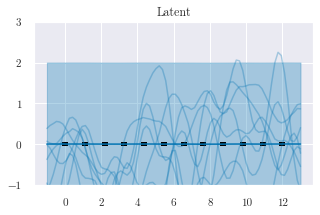

In [6]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))
plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=False, plot_inducing=False)


In [7]:
lfm.train()

trainer.train(10, report_interval=10, step_size=step_size)


Epoch 001/010 - Loss: 10.01 (10.01 0.00) λ: [0.6782597]


/Users/jacob/Documents/proj/reggae/lafomo/plot/plotter.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


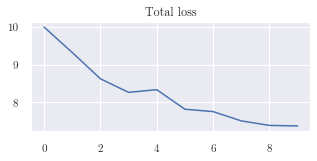

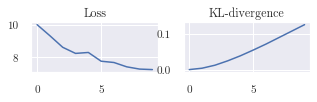

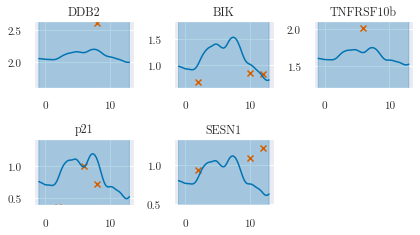

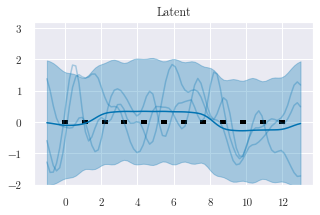

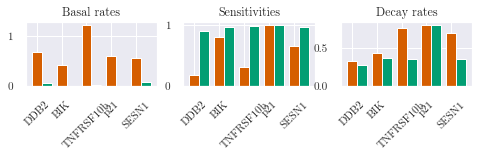

In [10]:
root_dir = '../../../'
experiment_dir = path.join(root_dir, 'experiments/variational')

lfm.eval()
plotter.plot_losses(trainer, last_x=200)
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))

plotter.plot_latents(t_predict, ylim=(-2, 3.2), plot_barenco=False, plot_inducing=False, num_samples=3)

labels = ['Basal rates', 'Decay rates', 'Sensitivities']
keys = ['basal_rate', 'decay_rate', 'sensitivity']
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())